In [1]:
import pandas as pd
import os

def load_datasets(base_path="/Users/diankartikaputri/Documents/FINAL-DEEP-LEARNING"):
    """
    Load all datasets from the project directory.
    """
    datasets = {}
    
    # Load train.csv and test.csv from root directory
    train_path = os.path.join(base_path, 'train.csv')
    test_path  = os.path.join(base_path, 'test.csv')

    datasets['train'] = pd.read_csv(train_path)
    datasets['test']  = pd.read_csv(test_path)
    
    # Load supplementary datasets from train_supplement/
    supplement_path = os.path.join(base_path, 'train_supplement')

    for i in range(1, 5):
        dataset_path = os.path.join(supplement_path, f'dataset{i}.csv')
        datasets[f'dataset{i}'] = pd.read_csv(dataset_path)

    return datasets


# Load the datasets
data = load_datasets()
train_df     = data['train']
test_df      = data['test']
dataset1_df  = data['dataset1']
dataset2_df  = data['dataset2']
dataset3_df  = data['dataset3']
dataset4_df  = data['dataset4']

In [2]:
from rdkit import Chem 
from rdkit.Chem import AllChem 
from rdkit.Chem.rdmolops import RemoveHs

def safe_mol_from_smiles(smiles):
    if pd.isna(smiles) or not isinstance(smiles, str) or smiles.strip() == '':
        return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except:
        return None
    
def largest_fragment(mol):
    frags = Chem.GetMolFrags(mol, asMols=True)
    if len(frags) == 1:
        return mol
    largest = max(frags, key=lambda m: m.GetNumAtoms())
    return largest

def neutralize_molecule(mol):
    try:
        # RDKit built-in neutralization
        uncharger = Chem.rdMolStandardize.Uncharger()
        mol = uncharger.uncharge(mol)
        return mol
    except:
        return mol
    
def canonicalize(mol):
    try:
        return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None
    
    
def sanitize_smiles_pipeline(smiles):
    # Step 1: Safe Mol
    mol = safe_mol_from_smiles(smiles)
    if mol is None:
        return None

    # Step 2: Remove salts
    mol = largest_fragment(mol)

    # Step 3: Neutralize
    mol = neutralize_molecule(mol)

    # Step 4: Re-sanitize
    try:
        Chem.SanitizeMol(mol)
    except:
        return None

    # Step 5: Canonicalize
    return canonicalize(mol)

In [3]:
# Replace your validate_smiles_entries call with this:

def validate_smiles_entries_dict(dfs_dict, smiles_column="SMILES"):
    """
    SMILES validation using explicit dictionary keys.
    """
    results = {}

    for df_name, df in dfs_dict.items():
        df_copy = df.copy()

        canonical_list = []
        errors = []

        for s in df_copy[smiles_column]:
            try:
                mol = Chem.MolFromSmiles(s, sanitize=True)
                if mol is None:
                    canonical_list.append(None)
                    errors.append({"SMILES": s, "error": "MolFromSmiles returned None"})
                else:
                    canon = Chem.MolToSmiles(mol, canonical=True)
                    canonical_list.append(canon)
                    errors.append(None)
            except Exception as e:
                canonical_list.append(None)
                errors.append({"SMILES": s, "error": str(e)})

        df_copy["canonical_SMILES"] = canonical_list
        df_copy["sanitization_error"] = errors

        # Summary QC
        total = len(df_copy)
        valid = df_copy["canonical_SMILES"].notna().sum()
        invalid = total - valid
        unique_raw = df_copy[smiles_column].nunique()
        unique_canon = df_copy["canonical_SMILES"].nunique()

        print("\n=====================================")
        print(f"🔎 QC for {df_name}")
        print("=====================================")
        print(f"Total entries:                  {total}")
        print(f"Valid sanitized molecules:      {valid}")
        print(f"Invalid molecules:              {invalid}")
        print(f"Raw unique SMILES:              {unique_raw}")
        print(f"Canonical unique SMILES:        {unique_canon}")
        print(f"Duplicates lost after cleaning: {unique_raw - unique_canon}")
        print("-------------------------------------")

        invalid_df = df_copy[df_copy["canonical_SMILES"].isna()]
        if len(invalid_df) > 0:
            print("❌ Invalid molecules found:")
            print(invalid_df[[smiles_column, "sanitization_error"]].head())
        else:
            print("✅ No invalid molecules.")

        results[df_name] = {
            "clean_df": df_copy[df_copy["canonical_SMILES"].notna()].copy(),
            "invalid_df": invalid_df.copy(),
            "full_df": df_copy,
        }

    return results

# Use explicit dictionary with names
checklist = {
    'test_df': test_df,
    'train_df': train_df,
    'dataset1_df': dataset1_df,
    'dataset2_df': dataset2_df,
    'dataset3_df': dataset3_df,
    'dataset4_df': dataset4_df
}

qc_results = validate_smiles_entries_dict(checklist)

# Now extract cleaned DataFrames
train_df = qc_results['train_df']['clean_df']
dataset1_df = qc_results['dataset1_df']['clean_df']
dataset2_df = qc_results['dataset2_df']['clean_df']
dataset3_df = qc_results['dataset3_df']['clean_df']
dataset4_df = qc_results['dataset4_df']['clean_df']
test_df = qc_results['test_df']['clean_df']


🔎 QC for test_df
Total entries:                  3
Valid sanitized molecules:      3
Invalid molecules:              0
Raw unique SMILES:              3
Canonical unique SMILES:        3
Duplicates lost after cleaning: 0
-------------------------------------
✅ No invalid molecules.

🔎 QC for train_df
Total entries:                  7973
Valid sanitized molecules:      7973
Invalid molecules:              0
Raw unique SMILES:              7973
Canonical unique SMILES:        7973
Duplicates lost after cleaning: 0
-------------------------------------
✅ No invalid molecules.

🔎 QC for dataset1_df
Total entries:                  874
Valid sanitized molecules:      874
Invalid molecules:              0
Raw unique SMILES:              867
Canonical unique SMILES:        866
Duplicates lost after cleaning: 1
-------------------------------------
✅ No invalid molecules.

🔎 QC for dataset2_df
Total entries:                  7208
Valid sanitized molecules:      7208
Invalid molecules:         

In [4]:
dataset_merge = [train_df, dataset1_df, dataset3_df, dataset4_df]
dataset_cluster = [dataset2_df]

def prepare_for_merge(df, key="canonical_SMILES"):
    """
    Remove duplicate SMILES columns and preserve only the key for merging.
    Keeps track of original row count and unique keys.
    """
    df = df.copy()
    
    # Drop raw SMILES if canonical is used for merge
    if "SMILES" in df.columns and key != "SMILES":
        df = df.drop(columns=["SMILES"])

    # Drop duplicate key rows
    before = len(df)
    df = df.drop_duplicates(subset=[key])
    after = len(df)

    print(f"[Prepare] Rows before={before}, after deduplicate={after}")
    return df
from functools import reduce

def robust_merge(datasets, key="canonical_SMILES"):
    """
    Safely merges multiple datasets on canonical SMILES.
    Logs before/after information for traceability.
    """
    # Prepare datasets
    cleaned = [prepare_for_merge(df, key=key) for df in datasets]

    # Log BEFORE merge stats
    print("\n===== BEFORE MERGE STATS =====")
    for i, df in enumerate(cleaned):
        print(f"Dataset {i+1}: rows={len(df)}, unique keys={df[key].nunique()}")

    # Reduce merge
    merged = reduce(
        lambda left, right: left.merge(
            right, on=key, how="outer", suffixes=("", "_dup")
        ),
        cleaned
    )

    # Clean leftover duplicate columns (_dup)
    dup_cols = [c for c in merged.columns if c.endswith("_dup")]
    if dup_cols:
        merged = merged.drop(columns=dup_cols)

    # Log AFTER merge stats
    print("\n===== AFTER MERGE STATS =====")
    print(f"Merged rows={len(merged)}")
    print(f"Merged unique keys={merged[key].nunique()}")

    return merged


def compare_augmentation(base_df, augmented_df, key="canonical_SMILES"):
    """
    Show which molecules the external datasets added.
    """
    base_keys = set(base_df[key])
    aug_keys = set(augmented_df[key])

    added = aug_keys - base_keys
    lost  = base_keys - aug_keys  # should be empty unless outer merge

    print("\n===== AUGMENTATION DIAGNOSTICS =====")
    print(f"New molecules added: {len(added)}")
    print(f"Molecules missing (should be 0): {len(lost)}")

    added_df = augmented_df[augmented_df[key].isin(added)]
    print("Example added rows:")
    print(added_df.head())

    return added_df

df_internal = robust_merge(dataset_merge, key="canonical_SMILES")
df_augmented = robust_merge([df_internal] + dataset_cluster)

augment_inspection = compare_augmentation(df_internal, df_augmented)

df_augmented = df_augmented.drop(columns=["sanitization_error","id"])
df_augmented

[Prepare] Rows before=7973, after deduplicate=7973
[Prepare] Rows before=874, after deduplicate=866
[Prepare] Rows before=46, after deduplicate=46
[Prepare] Rows before=862, after deduplicate=862

===== BEFORE MERGE STATS =====
Dataset 1: rows=7973, unique keys=7973
Dataset 2: rows=866, unique keys=866
Dataset 3: rows=46, unique keys=46
Dataset 4: rows=862, unique keys=862

===== AFTER MERGE STATS =====
Merged rows=8972
Merged unique keys=8972
[Prepare] Rows before=8972, after deduplicate=8972
[Prepare] Rows before=7208, after deduplicate=7174

===== BEFORE MERGE STATS =====
Dataset 1: rows=8972, unique keys=8972
Dataset 2: rows=7174, unique keys=7174

===== AFTER MERGE STATS =====
Merged rows=10343
Merged unique keys=10343

===== AUGMENTATION DIAGNOSTICS =====
New molecules added: 1371
Molecules missing (should be 0): 0
Example added rows:
   id  Tg  FFV  Tc  Density  Rg  \
0 NaN NaN  NaN NaN      NaN NaN   
1 NaN NaN  NaN NaN      NaN NaN   
2 NaN NaN  NaN NaN      NaN NaN   
3 NaN N

,Tg,FFV,Tc,Density,Rg,canonical_SMILES,TC_mean
0,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(C(C)(C)C)cc1)c1ccccc1,NaN
1,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(CCCC)cc1)c1ccccc1,NaN
2,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc(Oc2ccccc2)cc1)c1ccccc1,NaN
3,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C(C)C)(C(C)C)C(C)C)cc1)c1...,NaN
4,NaN,NaN,NaN,NaN,NaN,*/C(=C(/*)c1ccc([Si](C)(C)C)cc1)c1ccccc1,NaN
...,...,...,...,...,...,...,...
10338,NaN,NaN,0.38800,NaN,NaN,*c1sc(*)c(OCCCCCCCCCCCCCCCC)c1C,0.38800
10339,NaN,NaN,0.37475,0.904355,14.348260,*c1sc(*)c(OCCCCCCCCCCCCCCCCCCCC)c1C,0.37475
10340,NaN,NaN,0.44475,0.968872,15.087862,*c1sc(*)c2c1OCC(CCCCCCCCCCCCCCCC)O2,0.44475
10341,NaN,NaN,NaN,NaN,NaN,*c1sc(*)c2sc(CCCCCCCCC)nc12,0.48200


In [5]:
# Identify available columns
print("\n" + "="*60)
print("📊 AVAILABLE FEATURES IN AUGMENTED DATA")
print("="*60)

print("\nAll columns:")
print(df_augmented.columns.tolist())

# Define target columns (these are what we predict)
target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

# Get ALL numerical columns EXCEPT canonical_SMILES
# This includes target columns (they have numerical data too!)
numerical_columns = []
for col in df_augmented.columns:
    if col != 'canonical_SMILES':  # Only exclude SMILES identifier
        # Check if column is numeric (robust check)
        if pd.api.types.is_numeric_dtype(df_augmented[col]):
            numerical_columns.append(col)

print(f"\n📋 Target columns ({len(target_columns)}):")
for col in target_columns:
    print(f"   - {col}")

print(f"\n🔢 ALL Numerical feature columns ({len(numerical_columns)}):")
for col in numerical_columns:
    is_target = "⭐ TARGET" if col in target_columns else ""
    print(f"   - {col:20s} {is_target}")

if len(numerical_columns) > 0:
    print(f"\n📊 Feature coverage (including NaN values):")
    for col in numerical_columns:
        available = df_augmented[col].notna().sum()
        total = len(df_augmented)
        pct = (available / total) * 100
        is_target = "[TARGET]" if col in target_columns else "[FEATURE]"
        print(f"  {is_target:10s} {col:20s}: {available:6d} / {total:6d} ({pct:5.1f}%)")
    
    # Count non-target features
    non_target_features = [col for col in numerical_columns if col not in target_columns]
    
    print("\n" + "="*60)
    print(f"✅ Combined features for XGBoost:")
    print(f"   - GNN embeddings:      32 dimensions")
    print(f"   - Target columns:      {len(target_columns)} dimensions (will be used as features)")
    if len(non_target_features) > 0:
        print(f"   - Other numerical:     {len(non_target_features)} dimensions")
        print(f"   - TOTAL:              {32 + len(numerical_columns)} dimensions")
    else:
        print(f"   - TOTAL:              {32 + len(target_columns)} dimensions")
    print("="*60)
    
    print(f"\n⚠️  NOTE: Target columns with available values will be used as features")
    print(f"   Missing target values (NaN) will be filled with 0")
else:
    print("\n⚠️ No numerical features found!")
    print("   Will use GNN embeddings only (32 dimensions)")


📊 AVAILABLE FEATURES IN AUGMENTED DATA

All columns:
['Tg', 'FFV', 'Tc', 'Density', 'Rg', 'canonical_SMILES', 'TC_mean']

📋 Target columns (5):
   - Tg
   - FFV
   - Tc
   - Density
   - Rg

🔢 ALL Numerical feature columns (6):
   - Tg                   ⭐ TARGET
   - FFV                  ⭐ TARGET
   - Tc                   ⭐ TARGET
   - Density              ⭐ TARGET
   - Rg                   ⭐ TARGET
   - TC_mean              

📊 Feature coverage (including NaN values):
  [TARGET]   Tg                  :    511 /  10343 (  4.9%)
  [TARGET]   FFV                 :   7030 /  10343 ( 68.0%)
  [TARGET]   Tc                  :    737 /  10343 (  7.1%)
  [TARGET]   Density             :    613 /  10343 (  5.9%)
  [TARGET]   Rg                  :    614 /  10343 (  5.9%)
  [FEATURE]  TC_mean             :    866 /  10343 (  8.4%)

✅ Combined features for XGBoost:
   - GNN embeddings:      32 dimensions
   - Target columns:      5 dimensions (will be used as features)
   - Other numerical:    

In [6]:
import os

save_dir = "../data"  # relative dari src/
save_path = os.path.join(save_dir, "augmented_training_data.csv")

df_augmented.to_csv(save_path, index=False)


In [7]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import torch
from torch_geometric.data import Data
import numpy as np

def get_atom_features(atom):
    """
    Extract node features from RDKit atom object.
    Features: atomic number, valence, degree, formal charge, aromaticity
    """
    features = [
        atom.GetAtomicNum(),                    # Atomic number
        atom.GetTotalValence(),                 # Valence
        atom.GetDegree(),                       # Degree
        atom.GetFormalCharge(),                 # Formal charge
        int(atom.GetIsAromatic())               # Aromaticity (0 or 1)
    ]
    return features

def get_bond_features(bond):
    """
    Extract edge features from RDKit bond object.
    Features: bond type, conjugation, aromatic flags
    """
    bond_type_map = {
        Chem.BondType.SINGLE: 1,
        Chem.BondType.DOUBLE: 2,
        Chem.BondType.TRIPLE: 3,
        Chem.BondType.AROMATIC: 4
    }
    
    features = [
        bond_type_map.get(bond.GetBondType(), 0),  # Bond type
        int(bond.GetIsConjugated()),                # Conjugation
        int(bond.GetIsAromatic())                   # Aromatic flag
    ]
    return features

def smiles_to_graph(smiles):
    """
    Convert SMILES string to PyTorch Geometric Data object.
    
    Returns:
    --------
    Data object with:
        - x: node feature matrix [num_nodes, 5]
        - edge_index: edge connectivity [2, num_edges]
        - edge_attr: edge features [num_edges, 3]
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # Edge indices and features
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Add both directions (undirected graph)
        edge_indices.append([i, j])
        edge_indices.append([j, i])
        
        bond_feat = get_bond_features(bond)
        edge_features.append(bond_feat)
        edge_features.append(bond_feat)
    
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)



/Users/diankartikaputri/Documents/FINAL-DEEP-LEARNING/.venv311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pickle
import os
import torch
import pandas as pd

def custom_collate(batch):
    """
    Custom collate function for PyTorch Geometric batches.
    Handles None values from failed SMILES conversions.
    """
    # Filter out None values
    batch = [item for item in batch if item is not None]
    
    if len(batch) == 0:
        return None
    
    # Use PyG's Batch.from_data_list
    return Batch.from_data_list(batch)

print("✅ custom_collate function defined")

class CachedPolymerDataset(Dataset):
    """Pre-computes all graphs during initialization."""
    def __init__(self, df, target_columns=['Tg', 'FFV', 'Tc', 'Density', 'Rg'], cache_path=None):
        super().__init__()
        self.target_columns = target_columns
        
        # Filter valid rows
        valid_rows = df[target_columns].notna().any(axis=1)
        self.df = df[valid_rows].reset_index(drop=True)
        
        # Try to load cached graphs
        if cache_path and os.path.exists(cache_path):
            print(f"📂 Loading cached graphs from {cache_path}...")
            with open(cache_path, 'rb') as f:
                cached_data = pickle.load(f)
                self.graphs = cached_data['graphs']
                self.df = cached_data['df']
            print(f"✅ Loaded {len(self.graphs)} cached graphs")
        else:
            # Pre-compute all graphs
            print("🔄 Pre-computing molecular graphs (this may take a few minutes)...")
            self.graphs = []
            valid_indices = []
            
            for idx in tqdm(range(len(self.df)), desc="Converting SMILES to graphs"):
                smiles = self.df.iloc[idx]['canonical_SMILES']
                graph = smiles_to_graph(smiles)
                
                if graph is not None:
                    self.graphs.append(graph)
                    valid_indices.append(idx)
            
            # Keep only valid molecules
            self.df = self.df.iloc[valid_indices].reset_index(drop=True)
            
            print(f"✅ Cached {len(self.graphs)} valid graphs")
            
            # Save cache if path provided
            if cache_path:
                os.makedirs(os.path.dirname(cache_path), exist_ok=True)
                with open(cache_path, 'wb') as f:
                    pickle.dump({'graphs': self.graphs, 'df': self.df}, f)
                print(f"💾 Saved cache to {cache_path}")
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        # Clone graph to avoid mutation
        graph = self.graphs[idx].clone()
        row = self.df.iloc[idx]
        
        # Add targets
        targets = []
        target_mask = []
        for col in self.target_columns:
            val = row[col]
            if pd.isna(val):
                targets.append(0.0)
                target_mask.append(0)
            else:
                targets.append(float(val))
                target_mask.append(1)
        
        graph.y = torch.tensor([targets], dtype=torch.float)
        graph.y_mask = torch.tensor([target_mask], dtype=torch.float)
        
        return graph


class CachedSMILESOnlyDataset(Dataset):
    """Pre-computes graphs for SMILES-only (no targets)."""
    def __init__(self, df, cache_path=None):
        super().__init__()
        self.df = df.reset_index(drop=True)
        
        # Try to load cached graphs
        if cache_path and os.path.exists(cache_path):
            print(f"📂 Loading cached graphs from {cache_path}...")
            with open(cache_path, 'rb') as f:
                self.graphs = pickle.load(f)
            print(f"✅ Loaded {len(self.graphs)} cached graphs")
        else:
            print("🔄 Pre-computing graphs for all molecules...")
            self.graphs = []
            
            for idx in tqdm(range(len(self.df)), desc="Converting SMILES"):
                smiles = self.df.iloc[idx]['canonical_SMILES']
                graph = smiles_to_graph(smiles)
                self.graphs.append(graph)
            
            print(f"✅ Processed {len(self.graphs)} molecules")
            
            # Save cache
            if cache_path:
                os.makedirs(os.path.dirname(cache_path), exist_ok=True)
                with open(cache_path, 'wb') as f:
                    pickle.dump(self.graphs, f)
                print(f"💾 Saved cache to {cache_path}")
    
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return self.graphs[idx]


# Updated create_dataloaders function
def create_dataloaders(df, batch_size=32, train_split=0.8):
    """Create dataloaders with cached graphs."""
    # Use cached dataset
    dataset = CachedPolymerDataset(
        df, 
        cache_path='../data/cache/polymer_graphs_train.pkl'
    )
    
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    # ⚠️ WINDOWS FIX: Use num_workers=0 to avoid multiprocessing issues
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=custom_collate,
        num_workers=0,  # ← CHANGED: No workers for Windows
        pin_memory=False,  # ← CHANGED: Disable pin_memory
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        collate_fn=custom_collate,
        num_workers=0,  # ← CHANGED: No workers for Windows
        pin_memory=False,  # ← CHANGED: Disable pin_memory
    )
    
    return train_loader, val_loader


print("✅ Cached dataset classes defined (Windows-compatible mode)")

✅ custom_collate function defined
✅ Cached dataset classes defined (Windows-compatible mode)


In [9]:
# Add these imports at the TOP of your dataset cell (VSC-01192d95)
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pickle
import os
import torch

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool

class PolymerGNN(nn.Module):
    """
    3-layer Graph Convolutional Network for polymer property prediction.
    """
    def __init__(self, num_node_features=5, num_outputs=5, hidden_dim=64, embedding_dim=32):
        super(PolymerGNN, self).__init__()
        
        # Graph convolution layers
        self.conv1 = GraphConv(num_node_features, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, embedding_dim)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        
        # Dense layers for property prediction
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.fc2 = nn.Linear(64, num_outputs)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GCN layers with ReLU and batch norm
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        
        # Global mean pooling (32-dim embeddings)
        embeddings = global_mean_pool(x, batch)
        
        # Dense layers for final predictions
        x = F.relu(self.fc1(embeddings))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def get_embeddings(self, data):
        """Extract 32-dim molecular embeddings."""
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        
        return global_mean_pool(x, batch)
    
    
def extract_embeddings_for_xgboost(model, dataloader, device):
    """
    Extract 32D embeddings from GNN for all molecules.
    """
    model.eval()
    embeddings = []
    targets = []
    masks = []
    
    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue
            batch = batch.to(device)
            
            # Use get_embeddings() method
            emb = model.get_embeddings(batch)  # Shape: [batch_size, 32]
            
            embeddings.append(emb.cpu().numpy())
            targets.append(batch.y.cpu().numpy())
            masks.append(batch.y_mask.cpu().numpy())
    
    embeddings = np.vstack(embeddings)  # [num_samples, 32]
    targets = np.vstack(targets)        # [num_samples, 5]
    masks = np.vstack(masks)            # [num_samples, 5]
    
    return embeddings, targets, masks

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# ---------------------------------------------------------
# Masked MSE Loss
# ---------------------------------------------------------
def masked_mse_loss(pred, target, mask):
    """
    Compute MSE only over available target values.
    pred, target, mask = [batch, 5]
    """
    # Sanity reshape if dataloader flattens targets
    if target.dim() == 1:
        target = target.view(pred.shape[0], -1)
        mask   = mask.view(pred.shape[0], -1)

    loss = (pred - target) ** 2
    loss = loss * mask
    return loss.sum() / mask.sum().clamp(min=1)


# ---------------------------------------------------------
# Training loop for one epoch
# ---------------------------------------------------------
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, desc="Training"):
        if batch is None:
            continue

        batch = batch.to(device)

        optimizer.zero_grad()
        pred = model(batch)
        loss = masked_mse_loss(pred, batch.y, batch.y_mask)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / max(len(loader), 1)


# ---------------------------------------------------------
# Validation loop
# ---------------------------------------------------------
def validate(model, loader, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            if batch is None:
                continue

            batch = batch.to(device)
            pred = model(batch)
            loss = masked_mse_loss(pred, batch.y, batch.y_mask)
            total_loss += loss.item()

    return total_loss / max(len(loader), 1)


# ---------------------------------------------------------
# Full Training Procedure
# ---------------------------------------------------------
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    lr=1e-3,
    device=None
):
    # Resolve device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"\n🚀 Using device: {device}")

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=10,
        factor=0.5
    )

    best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss   = validate(model, val_loader, device)

        scheduler.step(val_loss)

        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            print("💾 Saved new best model!")

    print("\n🎉 Training complete! Best Val Loss:", best_val_loss)
    return model


In [11]:
import os
import numpy as np
import torch
from torch_geometric.loader import DataLoader
from tqdm import tqdm

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# ================================================================
# CONFIG
# ================================================================
target_columns = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']

print("\n" + "="*60)
print("🧬 PHASE 1: TRAIN GNN ON SMILES ONLY (NO NUMERICAL FEATURES)")
print("="*60)

# Filter data that has at least 1 target (untuk supervisi)
df_with_targets = df_augmented[df_augmented[target_columns].notna().any(axis=1)].copy()
df_with_targets = df_with_targets.reset_index(drop=True)

print(f"📊 Total molecules (df_augmented):       {len(df_augmented)}")
print(f"📚 Molecules with ≥1 target (used):      {len(df_with_targets)}")
print(f"\n⚠️  GNN will ONLY see SMILES → Graph structure")
print(f"   NO numerical features used in GNN training!")

# ================================================================
# PHASE 1: TRAIN GNN
# ================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n💻 Using device: {device}")

# Model
model = PolymerGNN(num_node_features=5, num_outputs=len(target_columns)).to(device)

# Dataloaders dari molecules yang punya target
train_loader, val_loader = create_dataloaders(
    df_with_targets,
    batch_size=32,
    train_split=0.8
)

print(f"📦 Training batches:    {len(train_loader)}")
print(f"📦 Validation batches:  {len(val_loader)}")

# Train GNN
model = train_model(model, train_loader, val_loader, num_epochs=50, device=device)

print("\n✅ GNN training complete!")
print("   GNN learned molecular representations from SMILES graph structure only")

# ================================================================
# PHASE 2: EXTRACT EMBEDDINGS FOR MOLECULES WITH TARGETS
# ================================================================
print("\n" + "="*60)
print("🔄 PHASE 2: EXTRACT EMBEDDINGS FOR LABELED MOLECULES")
print("="*60)

# Load best model (kalau kamu simpan di train_model)
if os.path.exists('best_model.pt'):
    model.load_state_dict(torch.load('best_model.pt', map_location=device))
    print("✅ Loaded best_model.pt")
else:
    print("⚠️ best_model.pt not found, using current model weights")

model.eval()

# Dataset + loader untuk df_with_targets saja
all_smiles_dataset = CachedSMILESOnlyDataset(
    df_with_targets,
    cache_path='../data/cache/with_targets_graphs.pkl'
)

all_smiles_loader = DataLoader(
    all_smiles_dataset,
    batch_size=64,
    shuffle=False,   # penting: order harus sama dengan df_with_targets
    collate_fn=custom_collate,
    num_workers=0,
    pin_memory=False
)

print(f"📊 Extracting embeddings for {len(df_with_targets)} labeled molecules...")

embeddings_list = []

with torch.no_grad():
    for batch in tqdm(all_smiles_loader, desc="Extracting embeddings"):
        if batch is None:
            continue
        
        batch = batch.to(device)
        emb = model.get_embeddings(batch)   # (batch_size, emb_dim)
        embeddings_list.append(emb.cpu().numpy())

all_embeddings = np.vstack(embeddings_list)

print(f"✅ Extracted embeddings shape: {all_embeddings.shape}")
# all_embeddings.shape = (N_labeled, emb_dim) = (len(df_with_targets), emb_dim)

# ================================================================
# PHASE 3: CONCATENATE EMBEDDINGS WITH NUMERICAL FEATURES
# ================================================================
print("\n" + "="*60)
print("🔗 PHASE 3: CONCATENATE EMBEDDINGS WITH NUMERICAL FEATURES")
print("="*60)

print(f"📊 Available numerical columns: {len(numerical_columns)}")
if len(numerical_columns) > 0:
    print(f"   Columns: {numerical_columns}")

# Numerical features diambil dari df_with_targets (bukan df_augmented)
if len(numerical_columns) > 0:
    numerical_features = df_with_targets[numerical_columns].fillna(0).values
    # numerical_features.shape = (N_labeled, num_num_features)

    # Shape check sebelum concat
    print(f"\n🔍 Shape check before concat:")
    print(f"   Embeddings:          {all_embeddings.shape}")
    print(f"   Numerical features:  {numerical_features.shape}")
    assert all_embeddings.shape[0] == numerical_features.shape[0], \
        "Row count mismatch between embeddings and numerical features!"

    # Concatenate: [embeddings | numerical features]
    X_combined = np.hstack([all_embeddings, numerical_features])
    
    print(f"\n📊 Combined feature matrix:")
    print(f"   Embeddings (from SMILES):  {all_embeddings.shape}")
    print(f"   Numerical features:        {numerical_features.shape}")
    print(f"   Combined:                  {X_combined.shape}")
    print(f"\n   Feature breakdown:")
    print(f"     - Dimensions 0-{all_embeddings.shape[1]-1}:   GNN embeddings")
    print(f"     - Dimensions {all_embeddings.shape[1]}-{X_combined.shape[1]-1}:  Numerical features")
else:
    X_combined = all_embeddings
    print(f"⚠️  No numerical features found → using embeddings only")
    print(f"   Using embeddings only: {X_combined.shape}")

# Targets & masks juga dari df_with_targets
y_all = df_with_targets[target_columns].values
mask_all = df_with_targets[target_columns].notna().astype(float).values
y_all = np.nan_to_num(y_all, nan=0.0)

print(f"\n✅ Target shape: {y_all.shape}")
print(f"✅ Mask shape:   {mask_all.shape}")

print(f"\n📊 Target availability:")
for i, col in enumerate(target_columns):
    available = int(mask_all[:, i].sum())
    pct = (available / len(mask_all)) * 100
    print(f"   {col:10s}: {available:6d} / {len(mask_all):6d} ({pct:5.1f}%)")

# ================================================================
# PHASE 4: TRAIN XGBOOST ON COMBINED FEATURES
# ================================================================
print("\n" + "="*60)
print("🌳 PHASE 4: TRAIN XGBOOST ON COMBINED FEATURES")
print("="*60)

# Sebenarnya df_with_targets sudah ≥1 target semua,
# tapi kita tetap jaga dengan has_target
has_target = mask_all.sum(axis=1) > 0

X_train_combined = X_combined[has_target]
y_train_combined = y_all[has_target]
mask_train_combined = mask_all[has_target]

print(f"📊 Training data selection:")
print(f"   Total labeled molecules:   {len(X_combined)}")
print(f"   With ≥1 target (used):     {len(X_train_combined)}")
print(f"   Without targets:           {len(X_combined) - len(X_train_combined)}")

print(f"\n📊 Feature dimension breakdown:")
print(f"   Total features:          {X_train_combined.shape[1]}")
print(f"     - GNN embeddings:      {all_embeddings.shape[1]}")
if len(numerical_columns) > 0:
    print(f"     - Numerical features:  {len(numerical_columns)}")
    print(f"\n   Numerical features used:")
    for col in numerical_columns:
        is_target = " (TARGET)" if col in target_columns else " (FEATURE)"
        print(f"     - {col}{is_target}")

# Train/val split
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_train_combined,
    y_train_combined,
    mask_train_combined,
    test_size=0.2,
    random_state=42
)

print(f"\n📦 Data split:")
print(f"   Train set: {len(X_train)} samples")
print(f"   Val set:   {len(X_val)} samples")

# Base XGBoost model
base_xgb = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model = MultiOutputRegressor(base_xgb)

print("\n🌳 Training XGBoost on combined features...")
print(f"   Input: [{all_embeddings.shape[1]} embeddings + {X_combined.shape[1] - all_embeddings.shape[1]} numerical]")
xgb_model.fit(X_train, y_train)
print("✅ XGBoost training complete!")

# ================================================================
# PHASE 4b: EVALUATION
# ================================================================
y_val_pred = xgb_model.predict(X_val)

property_names = target_columns
print("\n" + "="*70)
print("📊 XGBOOST PERFORMANCE (Embeddings + Numerical Features)")
print("="*70)

for i, prop in enumerate(property_names):
    mask_idx = mask_val[:, i] == 1
    
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        
        print(f"{prop:10s} | RMSE: {rmse:8.4f} | R²: {r2:7.4f} | Samples: {mask_idx.sum():5d}")
    else:
        print(f"{prop:10s} | No validation samples")

print("="*70)

# ================================================================
# PHASE 5: SAVE RESULTS
# ================================================================
print("\n" + "="*60)
print("💾 PHASE 5: SAVE RESULTS")
print("="*60)

os.makedirs('../data', exist_ok=True)

# Save combined features & targets (hanya untuk labeled molecules)
np.save('../data/combined_features.npy', X_combined)
np.save('../data/targets.npy', y_all)
np.save('../data/masks.npy', mask_all)

# Save embeddings
np.save('../data/molecule_embeddings.npy', all_embeddings)

# Save XGBoost model
import joblib
joblib.dump(xgb_model, '../data/xgboost_combined_model.pkl')

# Save feature metadata
feature_metadata = {
    'embedding_dim': int(all_embeddings.shape[1]),
    'numerical_features': numerical_columns,
    'total_features': int(X_combined.shape[1]),
    'target_columns': target_columns
}
joblib.dump(feature_metadata, '../data/feature_metadata.pkl')

print("✅ Saved:")
print("   - combined_features.npy         (embeddings + numerical)")
print("   - targets.npy                   (target values)")
print("   - masks.npy                     (availability mask)")
print("   - molecule_embeddings.npy       (embeddings only)")
print("   - xgboost_combined_model.pkl    (trained model)")
print("   - feature_metadata.pkl          (feature information)")

print(f"\n📊 Summary:")
print(f"   Total molecules (df_augmented):     {len(df_augmented)}")
print(f"   Labeled molecules used:             {len(df_with_targets)}")
print(f"   Embedding dimension:                {all_embeddings.shape[1]}")
print(f"   Numerical features:                 {len(numerical_columns)}")
print(f"   Combined features:                  {X_combined.shape[1]}")
print(f"   Molecules with ≥1 target:           {has_target.sum()}")


🧬 PHASE 1: TRAIN GNN ON SMILES ONLY (NO NUMERICAL FEATURES)
📊 Total molecules (df_augmented):       10343
📚 Molecules with ≥1 target (used):      7973

⚠️  GNN will ONLY see SMILES → Graph structure
   NO numerical features used in GNN training!

💻 Using device: cpu
📂 Loading cached graphs from ../data/cache/polymer_graphs_train.pkl...
✅ Loaded 707 cached graphs
📦 Training batches:    18
📦 Validation batches:  5

🚀 Using device: cpu


Training: 100%|██████████| 18/18 [00:00<00:00, 82.66it/s]



Epoch 1/50
Train Loss: 279.196786 | Val Loss: 210.398062
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 182.02it/s]



Epoch 2/50
Train Loss: 270.621885 | Val Loss: 198.404066
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 180.56it/s]



Epoch 3/50
Train Loss: 277.561796 | Val Loss: 180.861119
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 184.29it/s]



Epoch 4/50
Train Loss: 249.758670 | Val Loss: 165.803329
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 184.77it/s]



Epoch 5/50
Train Loss: 268.002291 | Val Loss: 150.005952
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 187.21it/s]



Epoch 6/50
Train Loss: 209.361568 | Val Loss: 136.137361
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 183.84it/s]



Epoch 7/50
Train Loss: 202.991761 | Val Loss: 130.046373
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 186.99it/s]



Epoch 8/50
Train Loss: 199.702804 | Val Loss: 127.073987
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 183.35it/s]



Epoch 9/50
Train Loss: 191.869831 | Val Loss: 124.263658
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 170.80it/s]



Epoch 10/50
Train Loss: 196.791866 | Val Loss: 121.004414
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 190.52it/s]



Epoch 11/50
Train Loss: 196.805068 | Val Loss: 117.530301
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 185.11it/s]



Epoch 12/50
Train Loss: 183.969274 | Val Loss: 116.340923
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 180.04it/s]



Epoch 13/50
Train Loss: 172.436143 | Val Loss: 112.393426
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 187.20it/s]



Epoch 14/50
Train Loss: 167.848505 | Val Loss: 110.646661
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 188.60it/s]



Epoch 15/50
Train Loss: 172.368053 | Val Loss: 105.125584
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 71.29it/s]



Epoch 16/50
Train Loss: 167.799449 | Val Loss: 97.305297
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 147.42it/s]



Epoch 17/50
Train Loss: 151.680363 | Val Loss: 94.534523
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 169.39it/s]



Epoch 18/50
Train Loss: 130.682741 | Val Loss: 101.320016


Training: 100%|██████████| 18/18 [00:00<00:00, 175.67it/s]



Epoch 19/50
Train Loss: 115.536609 | Val Loss: 97.910219


Training: 100%|██████████| 18/18 [00:00<00:00, 149.20it/s]



Epoch 20/50
Train Loss: 118.500000 | Val Loss: 87.496274
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 161.20it/s]



Epoch 21/50
Train Loss: 104.979047 | Val Loss: 91.179762


Training: 100%|██████████| 18/18 [00:00<00:00, 166.71it/s]



Epoch 22/50
Train Loss: 91.389760 | Val Loss: 84.117209
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 170.32it/s]



Epoch 23/50
Train Loss: 85.296402 | Val Loss: 79.909036
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 149.35it/s]



Epoch 24/50
Train Loss: 76.250424 | Val Loss: 79.689874
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 166.58it/s]



Epoch 25/50
Train Loss: 82.773113 | Val Loss: 81.146262


Training: 100%|██████████| 18/18 [00:00<00:00, 104.92it/s]



Epoch 26/50
Train Loss: 68.859447 | Val Loss: 83.706740


Training: 100%|██████████| 18/18 [00:00<00:00, 135.97it/s]



Epoch 27/50
Train Loss: 50.586394 | Val Loss: 79.629856
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 132.45it/s]



Epoch 28/50
Train Loss: 63.449792 | Val Loss: 98.960154


Training: 100%|██████████| 18/18 [00:00<00:00, 144.47it/s]



Epoch 29/50
Train Loss: 49.454736 | Val Loss: 89.379970


Training: 100%|██████████| 18/18 [00:00<00:00, 154.46it/s]



Epoch 30/50
Train Loss: 35.295994 | Val Loss: 70.639223
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 143.90it/s]



Epoch 31/50
Train Loss: 39.921220 | Val Loss: 73.286351


Training: 100%|██████████| 18/18 [00:00<00:00, 186.46it/s]



Epoch 32/50
Train Loss: 57.681529 | Val Loss: 90.421762


Training: 100%|██████████| 18/18 [00:00<00:00, 189.38it/s]



Epoch 33/50
Train Loss: 40.356259 | Val Loss: 84.104897


Training: 100%|██████████| 18/18 [00:00<00:00, 187.86it/s]



Epoch 34/50
Train Loss: 44.743095 | Val Loss: 82.100332


Training: 100%|██████████| 18/18 [00:00<00:00, 184.96it/s]



Epoch 35/50
Train Loss: 41.224947 | Val Loss: 86.161564


Training: 100%|██████████| 18/18 [00:00<00:00, 189.16it/s]



Epoch 36/50
Train Loss: 35.410293 | Val Loss: 72.617621


Training: 100%|██████████| 18/18 [00:00<00:00, 192.11it/s]



Epoch 37/50
Train Loss: 39.741496 | Val Loss: 125.498518


Training: 100%|██████████| 18/18 [00:00<00:00, 189.72it/s]



Epoch 38/50
Train Loss: 39.147100 | Val Loss: 72.707238


Training: 100%|██████████| 18/18 [00:00<00:00, 186.44it/s]



Epoch 39/50
Train Loss: 39.541829 | Val Loss: 81.186584


Training: 100%|██████████| 18/18 [00:00<00:00, 186.49it/s]



Epoch 40/50
Train Loss: 34.607401 | Val Loss: 79.982094


Training: 100%|██████████| 18/18 [00:00<00:00, 189.80it/s]



Epoch 41/50
Train Loss: 20.769985 | Val Loss: 75.423318


Training: 100%|██████████| 18/18 [00:00<00:00, 184.03it/s]



Epoch 42/50
Train Loss: 28.650988 | Val Loss: 76.212435


Training: 100%|██████████| 18/18 [00:00<00:00, 191.30it/s]



Epoch 43/50
Train Loss: 35.516975 | Val Loss: 76.924438


Training: 100%|██████████| 18/18 [00:00<00:00, 190.85it/s]



Epoch 44/50
Train Loss: 22.176479 | Val Loss: 70.529980
💾 Saved new best model!


Training: 100%|██████████| 18/18 [00:00<00:00, 189.02it/s]



Epoch 45/50
Train Loss: 25.543306 | Val Loss: 76.581558


Training: 100%|██████████| 18/18 [00:00<00:00, 191.33it/s]



Epoch 46/50
Train Loss: 31.326084 | Val Loss: 72.099088


Training: 100%|██████████| 18/18 [00:00<00:00, 188.76it/s]



Epoch 47/50
Train Loss: 26.969553 | Val Loss: 79.285410


Training: 100%|██████████| 18/18 [00:00<00:00, 176.81it/s]



Epoch 48/50
Train Loss: 41.630585 | Val Loss: 105.373149


Training: 100%|██████████| 18/18 [00:00<00:00, 188.02it/s]



Epoch 49/50
Train Loss: 31.646389 | Val Loss: 113.411001


Training: 100%|██████████| 18/18 [00:00<00:00, 188.96it/s]



Epoch 50/50
Train Loss: 27.722852 | Val Loss: 110.963329

🎉 Training complete! Best Val Loss: 70.52997951507568

✅ GNN training complete!
   GNN learned molecular representations from SMILES graph structure only

🔄 PHASE 2: EXTRACT EMBEDDINGS FOR LABELED MOLECULES
✅ Loaded best_model.pt
📂 Loading cached graphs from ../data/cache/with_targets_graphs.pkl...
✅ Loaded 7973 cached graphs
📊 Extracting embeddings for 7973 labeled molecules...


Extracting embeddings: 100%|██████████| 125/125 [00:00<00:00, 389.67it/s]


✅ Extracted embeddings shape: (7973, 32)

🔗 PHASE 3: CONCATENATE EMBEDDINGS WITH NUMERICAL FEATURES
📊 Available numerical columns: 6
   Columns: ['Tg', 'FFV', 'Tc', 'Density', 'Rg', 'TC_mean']

🔍 Shape check before concat:
   Embeddings:          (7973, 32)
   Numerical features:  (7973, 6)

📊 Combined feature matrix:
   Embeddings (from SMILES):  (7973, 32)
   Numerical features:        (7973, 6)
   Combined:                  (7973, 38)

   Feature breakdown:
     - Dimensions 0-31:   GNN embeddings
     - Dimensions 32-37:  Numerical features

✅ Target shape: (7973, 5)
✅ Mask shape:   (7973, 5)

📊 Target availability:
   Tg        :    511 /   7973 (  6.4%)
   FFV       :   7030 /   7973 ( 88.2%)
   Tc        :    737 /   7973 (  9.2%)
   Density   :    613 /   7973 (  7.7%)
   Rg        :    614 /   7973 (  7.7%)

🌳 PHASE 4: TRAIN XGBOOST ON COMBINED FEATURES
📊 Training data selection:
   Total labeled molecules:   7973
   With ≥1 target (used):     7973
   Without targets:         

In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# ================================================================
# WEIGHTED MAE (wMAE) METRIC - NeurIPS 2025 Official Metric
# ================================================================
def compute_wmae(y_true, y_pred, y_mask, property_names=['Tg', 'FFV', 'Tc', 'Density', 'Rg']):
    """
    Compute Weighted Mean Absolute Error (wMAE) as per NeurIPS 2025.
    
    Formula: wMAE = (1/N) * Σ w_ij * |y_ij - ŷ_ij|
    
    Three weighting principles:
    1. Scale normalization: prevents dominance by large-scale properties
    2. Inverse sqrt frequency weighting: higher weight for rare properties  
    3. Weight normalization: ensures weights sum to 1
    
    Parameters:
    -----------
    y_true : np.ndarray [N, 5]
        Ground truth values
    y_pred : np.ndarray [N, 5]
        Predicted values
    y_mask : np.ndarray [N, 5]
        Binary mask (1 = available, 0 = missing)
    property_names : list
        Names of properties
        
    Returns:
    --------
    float : wMAE score
    dict : Per-property metrics
    """
    N, num_props = y_true.shape
    
    # Step 1: Compute frequency for each property
    frequencies = y_mask.sum(axis=0)  # [5]
    
    # Step 2: Inverse square-root frequency weighting
    # Properties with fewer samples get higher weight
    freq_weights = 1.0 / np.sqrt(frequencies.clip(min=1))
    
    # Step 3: Scale normalization
    # Compute scale (std) for each property to prevent large-value dominance
    scales = []
    for j in range(num_props):
        available_vals = y_true[y_mask[:, j] == 1, j]
        if len(available_vals) > 1:
            scale = np.std(available_vals)
            scales.append(scale if scale > 0 else 1.0)
        else:
            scales.append(1.0)
    scales = np.array(scales)
    
    # Step 4: Compute absolute errors
    abs_errors = np.abs(y_true - y_pred)  # [N, 5]
    
    # Step 5: Apply mask (only count available targets)
    masked_errors = abs_errors * y_mask  # [N, 5]
    
    # Step 6: Compute raw weights (inverse sqrt freq / scale)
    raw_weights = freq_weights / scales  # [5]
    
    # Step 7: Normalize weights to sum to 1
    weights = raw_weights / raw_weights.sum()  # [5]
    
    # Step 8: Compute weighted errors per sample
    weighted_errors = masked_errors * weights  # [N, 5]
    
    # Step 9: Compute wMAE
    total_samples = y_mask.sum()
    wmae = weighted_errors.sum() / total_samples if total_samples > 0 else 0.0
    
    # Compute per-property metrics for analysis
    per_property = {}
    for j, prop in enumerate(property_names):
        mask_j = y_mask[:, j] == 1
        if mask_j.sum() > 0:
            mae_j = mean_absolute_error(y_true[mask_j, j], y_pred[mask_j, j])
            weighted_mae_j = mae_j * weights[j]
            
            per_property[prop] = {
                'MAE': mae_j,
                'Weighted_MAE': weighted_mae_j,
                'Weight': weights[j],
                'Frequency': int(frequencies[j]),
                'Scale (std)': scales[j],
                'Raw_Weight': raw_weights[j]
            }
    
    return wmae, per_property


print("✅ wMAE metric function defined")

✅ wMAE metric function defined


In [13]:
# ================================================================
print("\n" + "="*70)
print("📊 EVALUATION WITH wMAE (NeurIPS 2025 Official Metric)")
print("="*70)

# Compute wMAE on validation set
wmae_score, per_property_metrics = compute_wmae(
    y_val, 
    y_val_pred, 
    mask_val,
    property_names=target_columns
)

print(f"\n🎯 Overall wMAE Score: {wmae_score:.6f}")
print("\n" + "="*70)
print("Per-Property Analysis:")
print("="*70)
print(f"{'Property':<10} | {'MAE':>8} | {'Weight':>8} | {'wMAE':>8} | {'Freq':>6} | {'Scale':>8}")
print("-" * 70)

for prop in target_columns:
    if prop in per_property_metrics:
        metrics = per_property_metrics[prop]
        print(f"{prop:<10} | "
              f"{metrics['MAE']:8.4f} | "
              f"{metrics['Weight']:8.4f} | "
              f"{metrics['Weighted_MAE']:8.6f} | "
              f"{metrics['Frequency']:6d} | "
              f"{metrics['Scale (std)']:8.2f}")

print("="*70)

# Explanation of weights
print("\n📖 Weight Explanation:")
print("   Rare properties (low frequency) → Higher weight")
print("   Large-scale properties (high std) → Lower weight") 
print("   Ensures balanced evaluation across all properties")


📊 EVALUATION WITH wMAE (NeurIPS 2025 Official Metric)

🎯 Overall wMAE Score: 0.001412

Per-Property Analysis:
Property   |      MAE |   Weight |     wMAE |   Freq |    Scale
----------------------------------------------------------------------
Tg         |  12.4574 |   0.0004 | 0.004946 |    107 |   108.48
FFV        |   0.0026 |   0.3963 | 0.001048 |   1391 |     0.03
Tc         |   0.0020 |   0.3780 | 0.000767 |    165 |     0.09
Density    |   0.0149 |   0.2171 | 0.003229 |    143 |     0.17
Rg         |   0.1508 |   0.0082 | 0.001237 |    143 |     4.54

📖 Weight Explanation:
   Rare properties (low frequency) → Higher weight
   Large-scale properties (high std) → Lower weight
   Ensures balanced evaluation across all properties



📊 CREATING VISUALIZATIONS
   Creating scatter plots...
   Creating residual plots...
   Creating weight visualization...
   Creating MAE comparison...
   Creating error distribution...
   Creating availability heatmap...
   Creating performance summary...

✅ Saved visualization to: ../data/evaluation_results.png


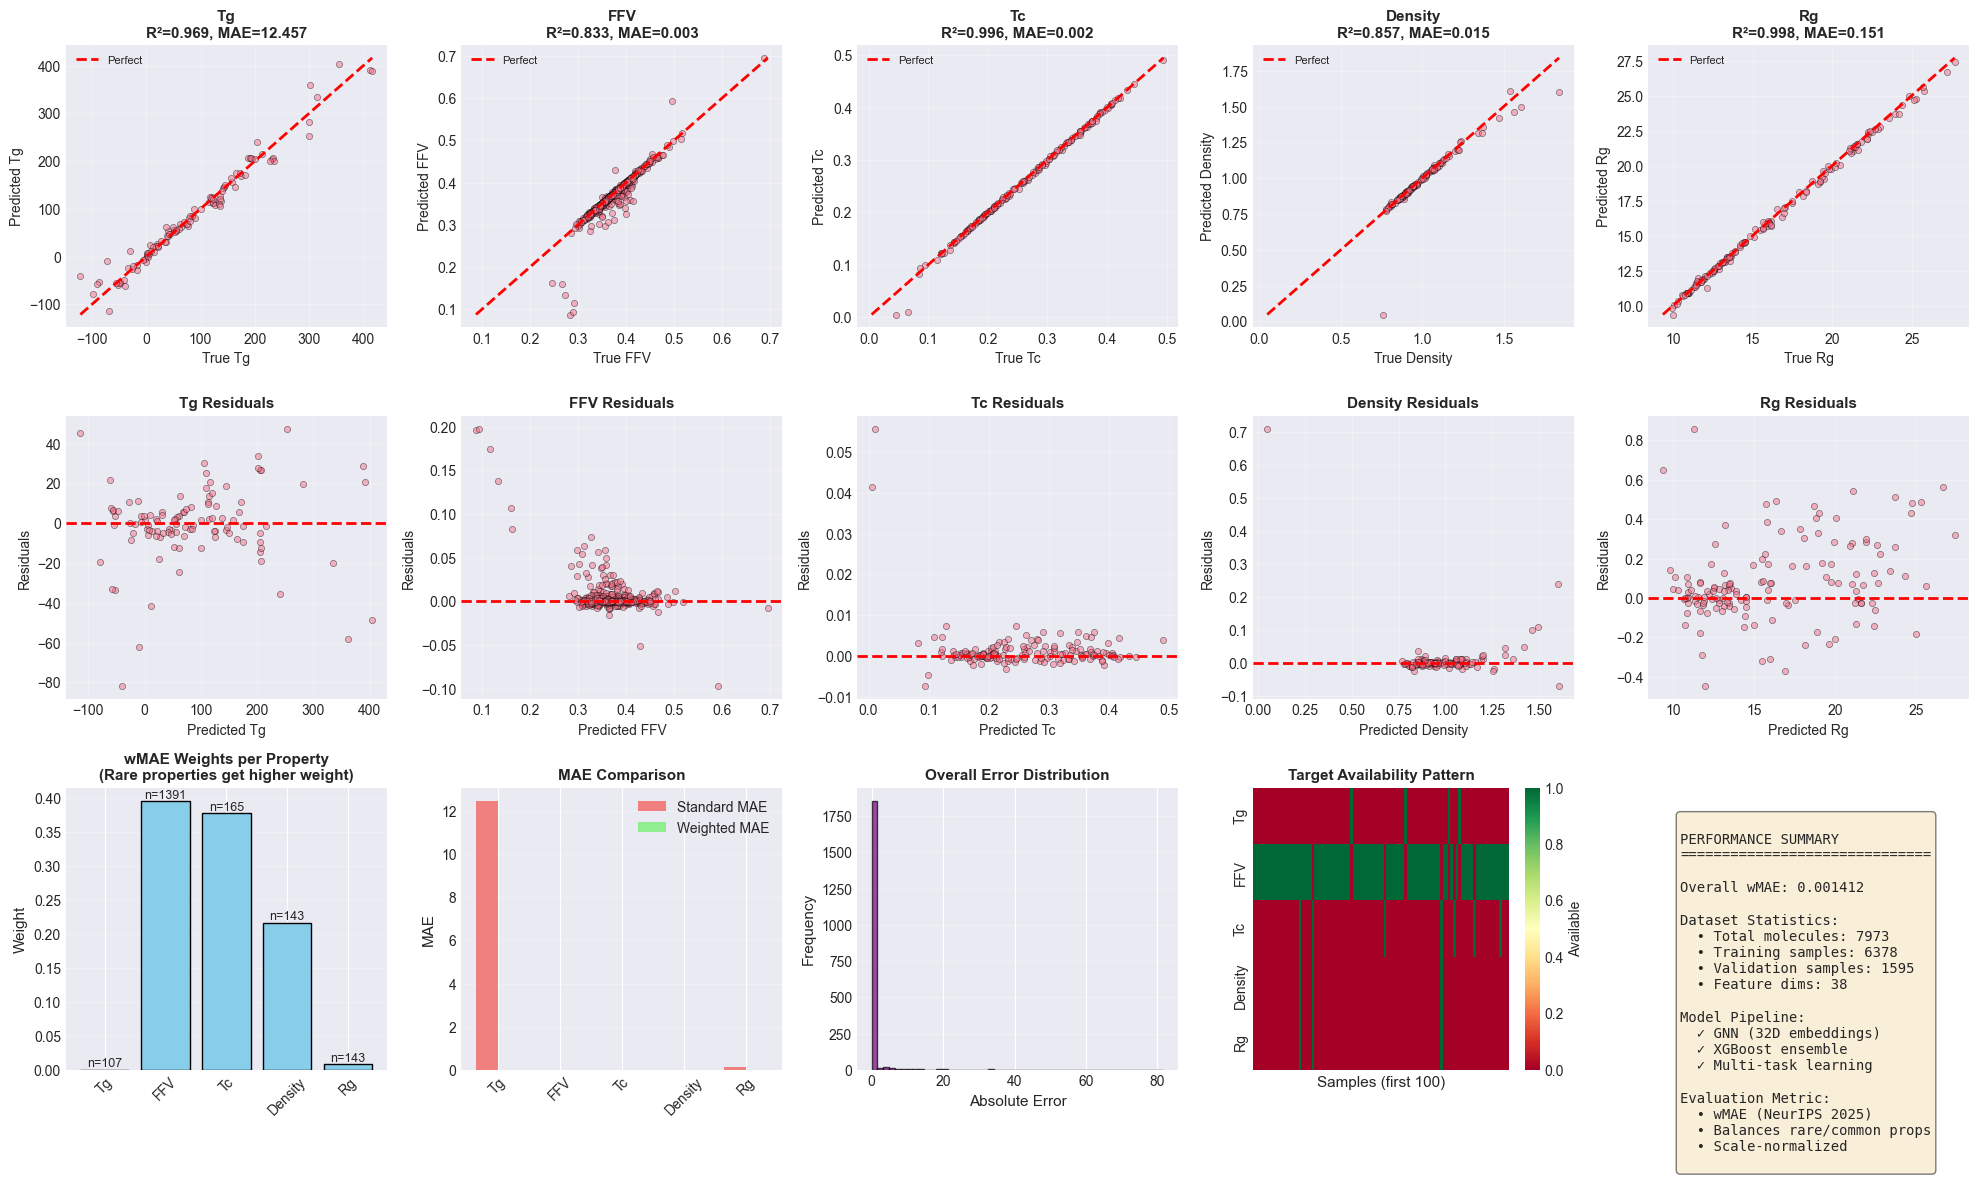


📊 Visualization complete!


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ================================================================
print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# ----------------------------------------------------------------
# 1. Prediction vs True Values (Scatter Plots)
# ----------------------------------------------------------------
print("   Creating scatter plots...")
for i, prop in enumerate(target_columns):
    ax = plt.subplot(3, 5, i + 1)
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        # Scatter plot
        ax.scatter(y_true, y_pred, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
        
        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
        
        # Compute metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        
        ax.set_xlabel(f'True {prop}', fontsize=10)
        ax.set_ylabel(f'Predicted {prop}', fontsize=10)
        ax.set_title(f'{prop}\nR²={r2:.3f}, MAE={mae:.3f}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

# ----------------------------------------------------------------
# 2. Residual Plots
# ----------------------------------------------------------------
print("   Creating residual plots...")
for i, prop in enumerate(target_columns):
    ax = plt.subplot(3, 5, i + 6)
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        residuals = y_true - y_pred
        
        # Residual scatter
        ax.scatter(y_pred, residuals, alpha=0.5, s=20, edgecolors='k', linewidths=0.5)
        ax.axhline(y=0, color='r', linestyle='--', lw=2)
        
        ax.set_xlabel(f'Predicted {prop}', fontsize=10)
        ax.set_ylabel('Residuals', fontsize=10)
        ax.set_title(f'{prop} Residuals', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)

# ----------------------------------------------------------------
# 3. Weight Visualization
# ----------------------------------------------------------------
print("   Creating weight visualization...")
ax = plt.subplot(3, 5, 11)

weights = [per_property_metrics[prop]['Weight'] for prop in target_columns if prop in per_property_metrics]
frequencies = [per_property_metrics[prop]['Frequency'] for prop in target_columns if prop in per_property_metrics]
props_list = [prop for prop in target_columns if prop in per_property_metrics]

bars = ax.bar(props_list, weights, color='skyblue', edgecolor='black')
ax.set_ylabel('Weight', fontsize=11)
ax.set_title('wMAE Weights per Property\n(Rare properties get higher weight)', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

# Add frequency as text on bars
for bar, freq in zip(bars, frequencies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'n={freq}',
            ha='center', va='bottom', fontsize=9)

# ----------------------------------------------------------------
# 4. MAE Comparison (Standard vs Weighted)
# ----------------------------------------------------------------
print("   Creating MAE comparison...")
ax = plt.subplot(3, 5, 12)

mae_standard = [per_property_metrics[prop]['MAE'] for prop in target_columns if prop in per_property_metrics]
mae_weighted = [per_property_metrics[prop]['Weighted_MAE'] for prop in target_columns if prop in per_property_metrics]

x = np.arange(len(props_list))
width = 0.35

bars1 = ax.bar(x - width/2, mae_standard, width, label='Standard MAE', color='lightcoral')
bars2 = ax.bar(x + width/2, mae_weighted, width, label='Weighted MAE', color='lightgreen')

ax.set_ylabel('MAE', fontsize=11)
ax.set_title('MAE Comparison', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(props_list, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# ----------------------------------------------------------------
# 5. Error Distribution
# ----------------------------------------------------------------
print("   Creating error distribution...")
ax = plt.subplot(3, 5, 13)

all_errors = []
for i, prop in enumerate(target_columns):
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        errors = np.abs(y_true - y_pred)
        all_errors.extend(errors)

ax.hist(all_errors, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax.set_xlabel('Absolute Error', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Overall Error Distribution', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# ----------------------------------------------------------------
# 6. Data Availability Heatmap
# ----------------------------------------------------------------
print("   Creating availability heatmap...")
ax = plt.subplot(3, 5, 14)

# Sample availability across properties
availability_matrix = mask_val[:100]  # Show first 100 samples
sns.heatmap(availability_matrix.T, cmap='RdYlGn', cbar_kws={'label': 'Available'},
            yticklabels=target_columns, xticklabels=False, ax=ax)
ax.set_xlabel('Samples (first 100)', fontsize=11)
ax.set_title('Target Availability Pattern', fontsize=11, fontweight='bold')

# ----------------------------------------------------------------
# 7. Performance Summary
# ----------------------------------------------------------------
print("   Creating performance summary...")
ax = plt.subplot(3, 5, 15)
ax.axis('off')

summary_text = f"""
PERFORMANCE SUMMARY
{"="*30}

Overall wMAE: {wmae_score:.6f}

Dataset Statistics:
  • Total molecules: {len(X_combined)}
  • Training samples: {len(X_train)}
  • Validation samples: {len(X_val)}
  • Feature dims: {X_combined.shape[1]}

Model Pipeline:
  ✓ GNN (32D embeddings)
  ✓ XGBoost ensemble
  ✓ Multi-task learning

Evaluation Metric:
  • wMAE (NeurIPS 2025)
  • Balances rare/common props
  • Scale-normalized
"""

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../data/evaluation_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved visualization to: ../data/evaluation_results.png")
plt.show()

print("\n📊 Visualization complete!")


📊 DETAILED PER-PROPERTY ANALYSIS
✅ Saved detailed analysis to: ../data/per_property_analysis.png


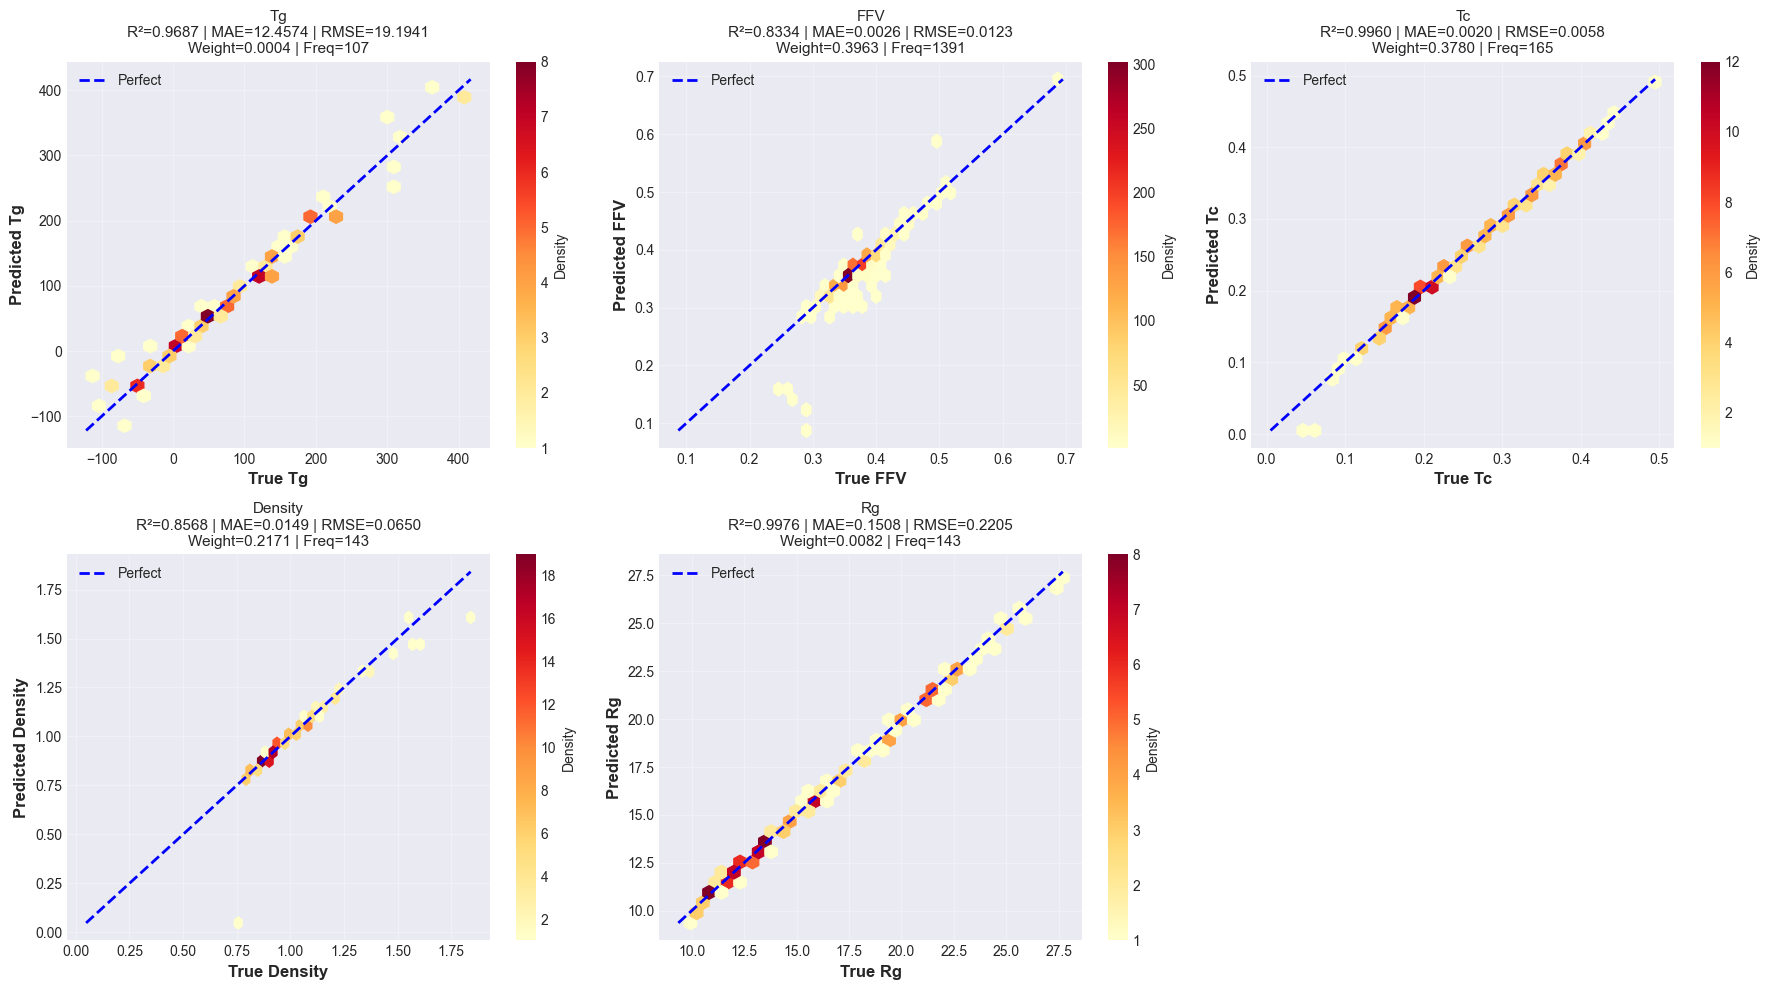

In [15]:
# ================================================================
print("\n" + "="*70)
print("📊 DETAILED PER-PROPERTY ANALYSIS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, prop in enumerate(target_columns):
    ax = axes[i]
    
    mask_idx = mask_val[:, i] == 1
    if mask_idx.sum() > 0:
        y_true = y_val[mask_idx, i]
        y_pred = y_val_pred[mask_idx, i]
        
        # Create hexbin plot for density
        hb = ax.hexbin(y_true, y_pred, gridsize=30, cmap='YlOrRd', mincnt=1)
        
        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'b--', lw=2, label='Perfect')
        
        # Compute detailed metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # Pearson correlation
        corr, _ = stats.pearsonr(y_true, y_pred)
        
        metrics = per_property_metrics[prop]
        
        ax.set_xlabel(f'True {prop}', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Predicted {prop}', fontsize=12, fontweight='bold')
        
        title_text = (f"{prop}\n"
                     f"R²={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}\n"
                     f"Weight={metrics['Weight']:.4f} | Freq={metrics['Frequency']}")
        ax.set_title(title_text, fontsize=11)
        
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(hb, ax=ax, label='Density')

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('../data/per_property_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved detailed analysis to: ../data/per_property_analysis.png")
plt.show()